# ONNX.js Variational Autoencoder (VAE)

In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import onnx
import numpy as np

In [27]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## MNIST

In [28]:
transforms = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(
    './data',
    train=True,
    download=True,
    transform=transforms)

test_dataset = datasets.MNIST(
    './data',
    train=False,
    download=True,
    transform=transforms
)

In [34]:
BATCH_SIZE, N_EPOCHS, lr = 64, 10, 1e-3
INPUT_DIM, HIDDEN_DIM, LATENT_DIM = 28*28, 256, 20                

train_iterator = DataLoader(train_dataset.data, batch_size=BATCH_SIZE, shuffle=True)
test_iterator = DataLoader(test_dataset.data, batch_size=BATCH_SIZE)

In [5]:
class Encoder(nn.Module):
        def __init__(self, input_dim, hidden_dim, z_dim):
            super().__init__()

            self.linear = nn.Linear(input_dim, hidden_dim)
            self.mu = nn.Linear(hidden_dim, z_dim)
            self.var = nn.Linear(hidden_dim, z_dim)

        def forward(self, x):
            hidden = F.relu(self.linear(x))
            z_mu = self.mu(hidden)
            z_var = self.var(hidden)
            return z_mu, z_var
        
class Decoder(nn.Module):
    def __init__(self, z_dim, hidden_dim, output_dim):
        super().__init__()
        self.linear = nn.Linear(z_dim, hidden_dim)
        self.out = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        hidden = F.relu(self.linear(x))
        predicted = torch.sigmoid(self.out(hidden))
        return predicted
    
    
class VAE(nn.Module):
        def __init__(self, enc, dec):
            super().__init__()
            self.enc = enc
            self.dec = dec

        def forward(self, x):
            z_mu, z_var = self.enc(x)
            std = torch.exp(z_var / 2)
            eps = torch.randn_like(std)
            x_sample = eps.mul(std).add_(z_mu)
            predicted = self.dec(x_sample)
            return predicted, z_mu, z_var

In [6]:
encoder = Encoder(INPUT_DIM, HIDDEN_DIM, LATENT_DIM)
decoder = Decoder(LATENT_DIM, HIDDEN_DIM, INPUT_DIM)
model = VAE(encoder, decoder).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

In [56]:
def train(model, train_iterator, optimizer):
        model.train()
        train_loss = 0
        for i, x in enumerate(train_iterator):
            x = x.view(-1, 28 * 28)
            optimizer.zero_grad()
            x_sample, z_mu, z_var = model(x.to(device))
            recon_loss = F.binary_cross_entropy(x_sample, x.to(device), size_average=False)
            kl_loss = 0.5 * torch.sum(torch.exp(z_var) + z_mu**2 - 1.0 - z_var)
            loss = recon_loss + kl_loss
            loss.backward()
            train_loss += loss.item()
            optimizer.step()

        return train_loss

In [57]:
def test(model, test_iterator):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, x in enumerate(test_iterator):
            x = x.view(-1, 28 * 28)
            x_sample, z_mu, z_var = model(x.to(device))
            recon_loss = F.binary_cross_entropy(x_sample, x.to(device), size_average=False)
            kl_loss = 0.5 * torch.sum(torch.exp(z_var) + z_mu**2 - 1.0 - z_var)
            loss = recon_loss + kl_loss
            test_loss += loss.item()

    return test_loss

In [48]:
for i in range(N_EPOCHS):
    train_loss = train(model, train_iterator, optimizer)
    test_loss = test(model, test_iterator)
    train_loss /= len(train_dataset)
    test_loss /= len(test_dataset)
    print('Epoch ' + str(i) + ', Train Loss: ' + str(round(train_loss, 2)) + ' Test Loss: ' + str(round(test_loss, 2)))

Epoch 0, Train Loss: 155.57, Test Loss: 124.72
Epoch 1, Train Loss: 120.26, Test Loss: 115.39
Epoch 2, Train Loss: 114.23, Test Loss: 111.89
Epoch 3, Train Loss: 111.72, Test Loss: 110.31
Epoch 4, Train Loss: 110.19, Test Loss: 109.02
Epoch 5, Train Loss: 109.20, Test Loss: 107.85
Epoch 6, Train Loss: 108.45, Test Loss: 107.59
Epoch 7, Train Loss: 107.89, Test Loss: 107.16
Epoch 8, Train Loss: 107.46, Test Loss: 106.71
Epoch 9, Train Loss: 107.04, Test Loss: 106.51
Epoch 10, Train Loss: 106.71, Test Loss: 106.13
Epoch 11, Train Loss: 106.46, Test Loss: 105.83
Epoch 12, Train Loss: 106.23, Test Loss: 105.76
Epoch 13, Train Loss: 106.02, Test Loss: 105.65
Epoch 14, Train Loss: 105.83, Test Loss: 105.38
Epoch 15, Train Loss: 105.68, Test Loss: 105.11
Epoch 16, Train Loss: 105.48, Test Loss: 105.13
Epoch 17, Train Loss: 105.31, Test Loss: 104.88
Epoch 18, Train Loss: 105.16, Test Loss: 104.72
Epoch 19, Train Loss: 105.06, Test Loss: 104.65


In [7]:
torch.save(model.state_dict(), "trained.pt")

In [9]:
class VAE2(nn.Module):
        def __init__(self, enc, dec):
            super().__init__()
            self.enc = enc
            self.dec = dec

        def forward(self, x):
            # Following https://www.youtube.com/watch?v=Vs730jsRgO8
            x, eps = x[0], x[1]
            x = x.reshape(280, 280, 4)
            x = torch.narrow(x, dim=2, start=3, length=1)
            x = x.reshape(1, 1, 280, 280)
            x = F.avg_pool2d(x, 10, stride=10, ceil_mode=False)
            x = x.view(-1, 28 * 28)
            x = x / 255
            z_mu, z_var = self.enc(x)
            std = torch.exp(z_var / 2)
            
            eps = eps.reshape(1, 20)
            x_sample = eps.mul(std).add_(z_mu)
            predicted = self.dec(x_sample)
            predicted /= (predicted.max()/255.0)
            predicted = predicted.view(28, 28)
            return predicted

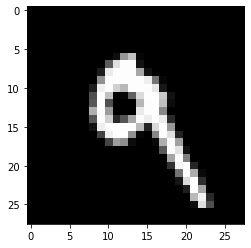

In [282]:
pre_trained = VAE2(encoder, decoder).to(device)
pre_trained.load_state_dict(torch.load('trained.pt'))
pre_trained.eval()

ex = test_dataset.data[7].float()

plt.imshow(ex, cmap='gray')
plt.show()

torch.Size([313600])
torch.Size([28, 28])
torch.Size([28, 28])


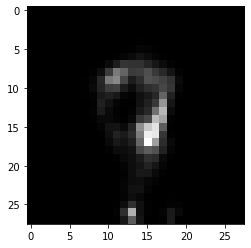

In [283]:
dummy_input = torch.zeros(280 * 280 * 4).float()
print(dummy_input.shape)
ep = torch.randn(1, 20)
x_t = pre_trained([dummy_input, ep])
print(x_t.shape)
img = x_t.view(28, 28).data

print(img.shape)

plt.imshow(img, cmap='gray')

In [284]:
torch.onnx.export(pre_trained, [dummy_input , ep], "onnx_model.onnx", verbose=True, opset_version=10)

graph(%0 : Float(313600),
      %1 : Float(1, 20),
      %enc.linear.weight : Float(256, 784),
      %enc.linear.bias : Float(256),
      %enc.mu.weight : Float(20, 256),
      %enc.mu.bias : Float(20),
      %enc.var.weight : Float(20, 256),
      %enc.var.bias : Float(20),
      %dec.linear.weight : Float(256, 20),
      %dec.linear.bias : Float(256),
      %dec.out.weight : Float(784, 256),
      %dec.out.bias : Float(784)):
  %12 : Tensor = onnx::Constant[value= 280  280    4 [ CPULongType{3} ]]()
  %13 : Float(280, 280, 4) = onnx::Reshape(%0, %12) # <ipython-input-281-b7584c848e0e>:13:0
  %14 : Tensor = onnx::Constant[value={2}]()
  %15 : Tensor = onnx::Constant[value={3}]()
  %16 : Tensor = onnx::Constant[value={4}]()
  %17 : Float(280, 280, 1) = onnx::Slice(%13, %15, %16, %14) # <ipython-input-281-b7584c848e0e>:14:0
  %18 : Tensor = onnx::Constant[value=   1    1  280  280 [ CPULongType{4} ]]()
  %19 : Float(1, 1, 280, 280) = onnx::Reshape(%17, %18) # <ipython-input-281-b7584c84

## Rotated MNIST

In [58]:
mnist_train = torch.Tensor(np.load('data/mnist_rotated/images_train.npy'))
mnist_val = torch.Tensor(np.load('data/mnist_rotated/images_test.npy'))
mnist_train = (mnist_train.float() - torch.min(mnist_train)) / (torch.max(mnist_train) - 
                                                                torch.min(mnist_train))
mnist_val = (mnist_val.float() - torch.min(mnist_val)) / (torch.max(mnist_val) - 
                                                                torch.min(mnist_val))
train_iterator2 = DataLoader(mnist_train, batch_size=BATCH_SIZE, shuffle=True)
test_iterator2 = DataLoader(mnist_val, batch_size=BATCH_SIZE)

encoder = Encoder(INPUT_DIM, HIDDEN_DIM, LATENT_DIM)
decoder = Decoder(LATENT_DIM, HIDDEN_DIM, INPUT_DIM)
model2 = VAE(encoder, decoder).to(device)
optimizer2 = optim.Adam(model2.parameters(), lr=lr)

In [59]:
for i in range(N_EPOCHS):
    train_loss = train(model2, train_iterator2, optimizer2)
    test_loss = test(model2, test_iterator2)
    train_loss /= len(mnist_train)
    test_loss /= len(mnist_val)
    print('Epoch ' + str(i) + ', Train Loss: ' + str(round(train_loss, 2)) + ' Test Loss: ' + str(round(test_loss, 2)))

Epoch 0, Train Loss: 184.05, Test Loss: 148.71
Epoch 1, Train Loss: 144.25, Test Loss: 139.52
Epoch 2, Train Loss: 138.53, Test Loss: 136.18
Epoch 3, Train Loss: 135.80, Test Loss: 134.31
Epoch 4, Train Loss: 134.28, Test Loss: 132.93
Epoch 5, Train Loss: 133.15, Test Loss: 132.22
Epoch 6, Train Loss: 132.36, Test Loss: 131.69
Epoch 7, Train Loss: 131.80, Test Loss: 131.17
Epoch 8, Train Loss: 131.29, Test Loss: 130.91
Epoch 9, Train Loss: 130.88, Test Loss: 130.61


In [62]:
torch.save(model2.state_dict(), "trained2.pt")

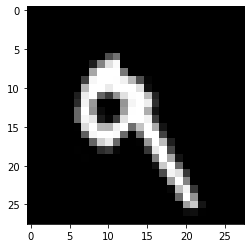

In [66]:
pre_trained2 = VAE2(encoder, decoder).to(device)
pre_trained2.load_state_dict(torch.load('trained2.pt'))
pre_trained2.eval()

ex = mnist_val[7].float()

plt.imshow(ex, cmap='gray')
plt.show()

torch.Size([313600])
torch.Size([28, 28])
torch.Size([28, 28])


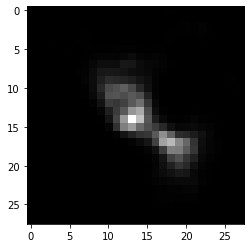

In [75]:
dummy_input = torch.zeros(280 * 280 * 4).float()
print(dummy_input.shape)
ep = torch.randn(1, 20)
x_t = pre_trained2([dummy_input, ep])
print(x_t.shape)
img = x_t.view(28, 28).data

print(img.shape)

plt.imshow(img, cmap='gray')

In [76]:
torch.onnx.export(pre_trained2, [dummy_input , ep], "onnx_model2.onnx", verbose=True, opset_version=10)

graph(%0 : Float(313600),
      %1 : Float(1, 20),
      %enc.linear.weight : Float(256, 784),
      %enc.linear.bias : Float(256),
      %enc.mu.weight : Float(20, 256),
      %enc.mu.bias : Float(20),
      %enc.var.weight : Float(20, 256),
      %enc.var.bias : Float(20),
      %dec.linear.weight : Float(256, 20),
      %dec.linear.bias : Float(256),
      %dec.out.weight : Float(784, 256),
      %dec.out.bias : Float(784)):
  %12 : Tensor = onnx::Constant[value= 280  280    4 [ CPULongType{3} ]]()
  %13 : Float(280, 280, 4) = onnx::Reshape(%0, %12) # <ipython-input-9-b7584c848e0e>:13:0
  %14 : Tensor = onnx::Constant[value={2}]()
  %15 : Tensor = onnx::Constant[value={3}]()
  %16 : Tensor = onnx::Constant[value={4}]()
  %17 : Float(280, 280, 1) = onnx::Slice(%13, %15, %16, %14) # <ipython-input-9-b7584c848e0e>:14:0
  %18 : Tensor = onnx::Constant[value=   1    1  280  280 [ CPULongType{4} ]]()
  %19 : Float(1, 1, 280, 280) = onnx::Reshape(%17, %18) # <ipython-input-9-b7584c848e0e>:

## Rotated and Translated MNIST

In [60]:
mnist_train2 = torch.Tensor(np.load('data/mnist_rotated_translated/images_train.npy'))
mnist_val2 = torch.Tensor(np.load('data/mnist_rotated_translated/images_test.npy'))
mnist_train2 = (mnist_train2.float() - torch.min(mnist_train2)) / (torch.max(mnist_train2) - 
                                                                torch.min(mnist_train2))
mnist_val2 = (mnist_val2.float() - torch.min(mnist_val2)) / (torch.max(mnist_val2) - 
                                                                torch.min(mnist_val2))
train_iterator3 = DataLoader(mnist_train2, batch_size=BATCH_SIZE, shuffle=True)
test_iterator3 = DataLoader(mnist_val2, batch_size=BATCH_SIZE)

encoder = Encoder(INPUT_DIM, HIDDEN_DIM, LATENT_DIM)
decoder = Decoder(LATENT_DIM, HIDDEN_DIM, INPUT_DIM)
model3 = VAE(encoder, decoder).to(device)
optimizer3 = optim.Adam(model3.parameters(), lr=lr)

In [61]:
for i in range(N_EPOCHS):
    train_loss = train(model3, train_iterator3, optimizer3)
    test_loss = test(model3, test_iterator3)
    train_loss /= len(mnist_train2)
    test_loss /= len(mnist_val2)
    print('Epoch ' + str(i) + ', Train Loss: ' + str(round(train_loss, 2)) + ' Test Loss: ' + str(round(test_loss, 2)))

Epoch 0, Train Loss: 189.87, Test Loss: 152.20
Epoch 1, Train Loss: 145.95, Test Loss: 141.67
Epoch 2, Train Loss: 139.92, Test Loss: 138.26
Epoch 3, Train Loss: 137.12, Test Loss: 136.01
Epoch 4, Train Loss: 135.28, Test Loss: 134.30
Epoch 5, Train Loss: 133.96, Test Loss: 133.32
Epoch 6, Train Loss: 133.01, Test Loss: 132.80
Epoch 7, Train Loss: 132.18, Test Loss: 132.15
Epoch 8, Train Loss: 131.63, Test Loss: 131.52
Epoch 9, Train Loss: 131.11, Test Loss: 131.17


In [77]:
torch.save(model2.state_dict(), "trained3.pt")

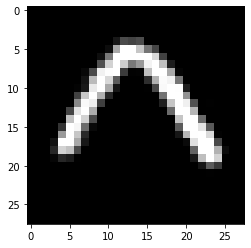

In [82]:
pre_trained3 = VAE2(encoder, decoder).to(device)
pre_trained3.load_state_dict(torch.load('trained3.pt'))
pre_trained3.eval()

ex = mnist_val2[17].float()

plt.imshow(ex, cmap='gray')
plt.show()

torch.Size([313600])
torch.Size([28, 28])
torch.Size([28, 28])


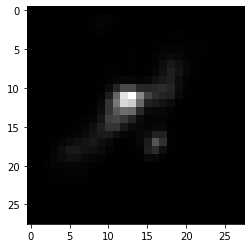

In [85]:
dummy_input = torch.zeros(280 * 280 * 4).float()
print(dummy_input.shape)
ep = torch.randn(1, 20)
x_t = pre_trained3([dummy_input, ep])
print(x_t.shape)
img = x_t.view(28, 28).data

print(img.shape)

plt.imshow(img, cmap='gray')

In [86]:
torch.onnx.export(pre_trained3, [dummy_input , ep], "onnx_model3.onnx", verbose=True, opset_version=10)

graph(%0 : Float(313600),
      %1 : Float(1, 20),
      %enc.linear.weight : Float(256, 784),
      %enc.linear.bias : Float(256),
      %enc.mu.weight : Float(20, 256),
      %enc.mu.bias : Float(20),
      %enc.var.weight : Float(20, 256),
      %enc.var.bias : Float(20),
      %dec.linear.weight : Float(256, 20),
      %dec.linear.bias : Float(256),
      %dec.out.weight : Float(784, 256),
      %dec.out.bias : Float(784)):
  %12 : Tensor = onnx::Constant[value= 280  280    4 [ CPULongType{3} ]]()
  %13 : Float(280, 280, 4) = onnx::Reshape(%0, %12) # <ipython-input-9-b7584c848e0e>:13:0
  %14 : Tensor = onnx::Constant[value={2}]()
  %15 : Tensor = onnx::Constant[value={3}]()
  %16 : Tensor = onnx::Constant[value={4}]()
  %17 : Float(280, 280, 1) = onnx::Slice(%13, %15, %16, %14) # <ipython-input-9-b7584c848e0e>:14:0
  %18 : Tensor = onnx::Constant[value=   1    1  280  280 [ CPULongType{4} ]]()
  %19 : Float(1, 1, 280, 280) = onnx::Reshape(%17, %18) # <ipython-input-9-b7584c848e0e>: